<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px;">

## Neural networks and backpropagation

Week 11 | 3.1

---

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# from draw_nnet import draw_neural_net

In [3]:
def draw_neural_net(ax, layer_sizes, layer_activations=None, weights=None,
                    left=0.1, right=0.9, bottom=0.1, top=0.9):
    '''
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(max(layer_sizes), 2))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in xrange(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            if layer_activations is not None:
                act = layer_activations[n][m]
                if not isinstance(act, str):
                    act = "{0:.2f}".format(act)
                    fontsize = 14
                else:
                    fontsize = 18
                ax.text(n*h_spacing + left, layer_top - m*v_spacing,
                        act, ha='center', va='center', zorder=5, fontsize=fontsize)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in xrange(layer_size_a):
            for o in xrange(layer_size_b):
                color = 'k'
                lw = 2.
                if weights is not None:
                    W = weights[n]
                    if len(W.shape) == 2:
                        w = W[m, o]
                    else:
                        w = W[o]
                    if w < 0:
                        color = 'darkred'
                    lw = 0.5 + 2*np.abs(w)
                    
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], 
                                  c=color, lw=lw)
                ax.add_artist(line)

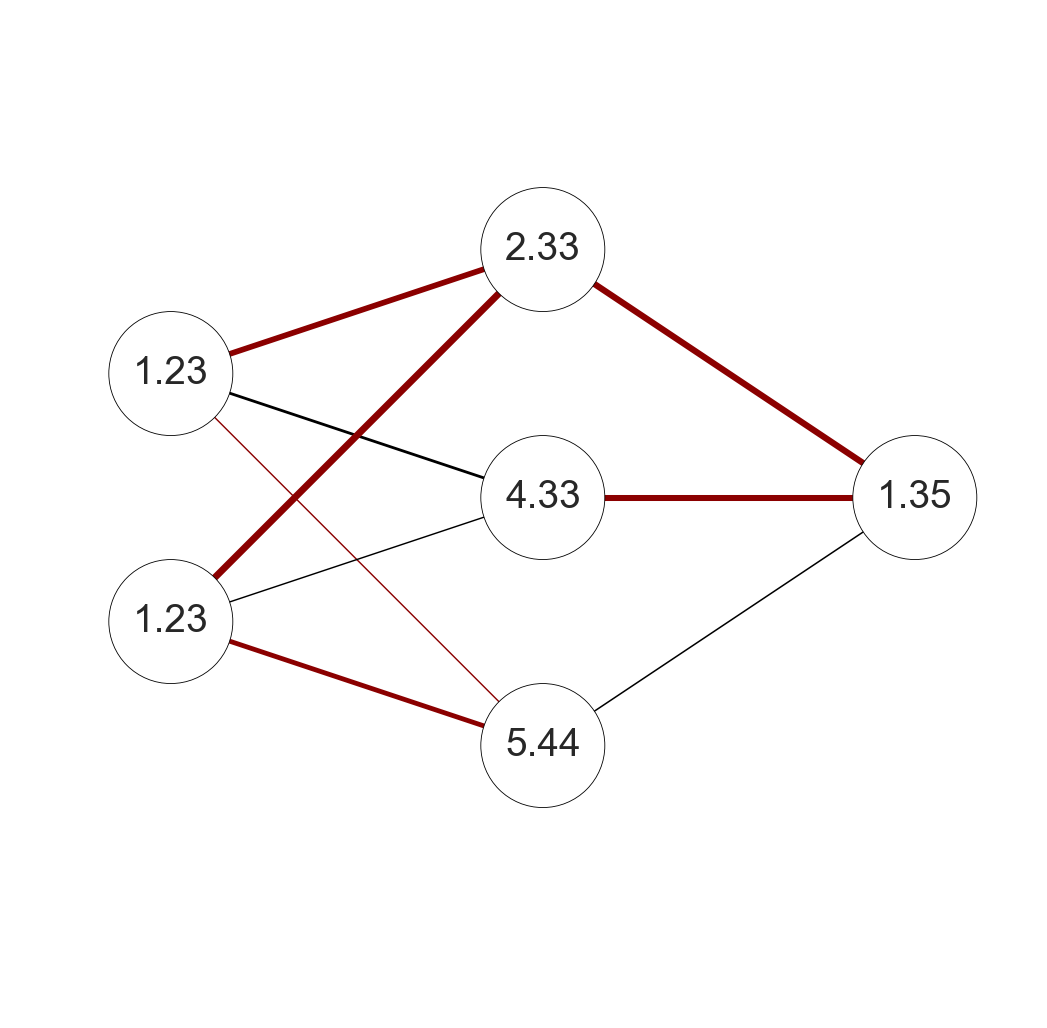

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
draw_neural_net(ax, [2, 3, 1], layer_activations=[[1.23, 1.23], [2.33, 4.33, 5.44], [1.34555]],
                weights=[np.random.normal(0,1, size=(2,3)), np.random.normal(0,1,size=(3,1))])


This is a feed-forward neural network with three layers. The first layer is typically called the "input layer" and the final layer is called the "output layer". 

In a basic feed-forward neural network, the layers between the input and output are referred to as _hidden_ layers. The implication is that their values are not observed, whereas the values of the inputs and outputs are.

In the network above we have 2 input neurons, 3 hidden layer neurons, and one output neuron. We can define representations of these using numpy.

In [5]:
input_act = np.zeros(2)
hidden_act = np.zeros(3)
output_act = np.zeros(1)

print input_act, hidden_act, output_act

[ 0.  0.] [ 0.  0.  0.] [ 0.]


Let $a_j^i$ represent the activation of the $j$th neuron in the $i$th layer.

$\sigma$ is what's called an "activation function". More on this later, but it modifies the activation of neurons.

$w_{jk}^i$ represents the weight of the activation in the $k$th neuron in the $i-1$ layer to the $j$th neuron in the $i$th layer.

$a_k^{i-1}$ is the activation of the $k$th neuron in the $i-1$th layer.

$b_j^i$ is the "bias" of the $j$th neuron in the $i$th layer.

We can write the equation for the activation of the $j$th neuron in the $i$th layer as:

### $$ a_j^i = \sigma \left( \sum_k w_{jk}^i a_k^{i-1} + b_j^i \right)$$

Which is somewhat cumbersome, but the gist of it is that each neuron is a sum of the weighted activations of neurons that feed into it plus a "bias" value.


It is cleaner to write the formula in matrix notation. Here is the vectorized version of the formula above:

### $$ a^i = \sigma(W^i a^{i-1} + b^i) $$

We formulate this with a weight matrix $W^i$ for each layer $i$. The weight matrix defines the weightings on the previous layer neuron activations to the neurons of the current layer. 

---

### Coding the forward propagation

Let's start with a demo of how the activations are propagated forward with our basic neural network architecture. We can do this with both formulas for clarity.

First write a function to calculate the activation of a **single** neuron given arguments:

    nerurons
    neuron_weights
    bias
    activation_func

In [17]:
def linear(x):
    return x

In [18]:
def single_activation(neurons, neuron_weights, bias, activation_func=linear):
    
    activation = 0.
    for n, w in zip(neurons, neuron_weights):
        activation += n*w
    activation += bias
    activation = activation_func(activation)
    return activation

In [20]:
single_activation([1., 2., 3.], [0.5, 0.5, 0.5], bias=10.)

13.0

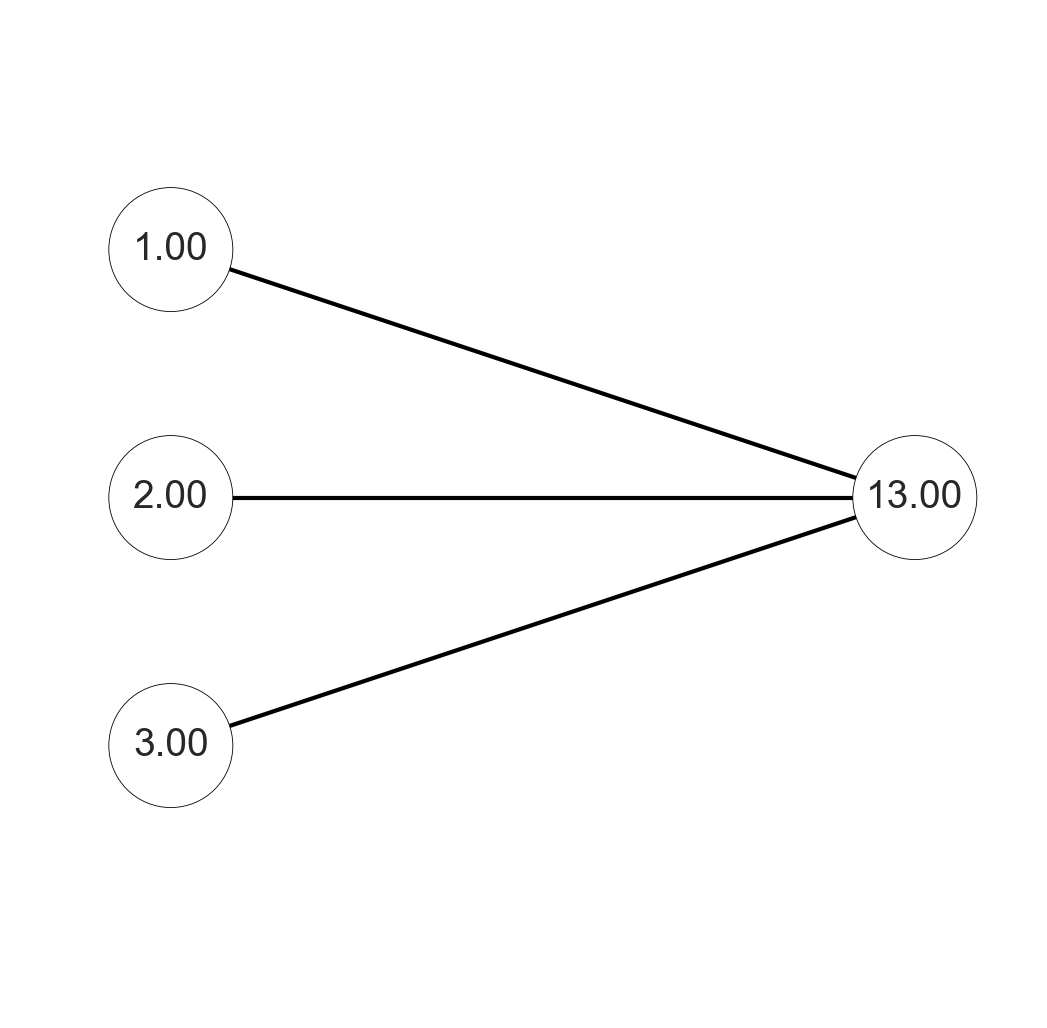

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
draw_neural_net(ax, [3, 1], layer_activations=np.array([[1,2,3], [13]]),
                weights=np.array([[0.5, 0.5, 0.5]]))

If we have the function to calculate activation for a single neuron, we can write a function to calculate an entire layer-to-layer forward propagation. This function will accept arguments:

    layer_in
    in_out_weights
    layer_out_biases
    activation_function
    
The `in_out_weights` will be a matrix or list of lists that specifies the weightings for each of the input neuron activations to all of the neurons in the output layer. The biases will be a vector the same length as the output layer.

Assume that the layers in and out are represented as 1D vectors (rather than "column" format where the activations are row by row in a single column of a 2D matrix).

In [61]:
def layer_activation(layer_in, in_out_weights, layer_out_biases, activation_func=linear):
    activations = np.zeros(in_out_weights.shape[1])
    print 'initial activations:', activations
    for col in range(in_out_weights.shape[1]):
        current_weights = in_out_weights[:, col]
        print 'current weights:', current_weights
        current_bias = layer_out_biases[col]
        activations[col] = single_activation(layer_in, current_weights, current_bias,
                                            activation_func=activation_func)
    return activations

We can test it out below. Initialize the inputs, weights, and biases to calculate the hidden layer:

In [62]:
input_act = np.random.uniform(-1, 1, size=2)
input_to_hidden = np.random.randn(2, 3)
hidden_biases = np.ones(3)

print input_act
print input_to_hidden
print hidden_biases

[ 0.54912476  0.73639401]
[[ 0.23430595 -1.32689931 -0.71652572]
 [-1.63594426  1.139085   -0.02900285]]
[ 1.  1.  1.]


In [63]:
hidden_act = layer_activation(input_act, input_to_hidden, hidden_biases)
hidden_act

initial activations: [ 0.  0.  0.]
current weights: [ 0.23430595 -1.63594426]
current weights: [-1.32689931  1.139085  ]
current weights: [-0.71652572 -0.02900285]


array([-0.07603635,  1.1101821 ,  0.58518045])

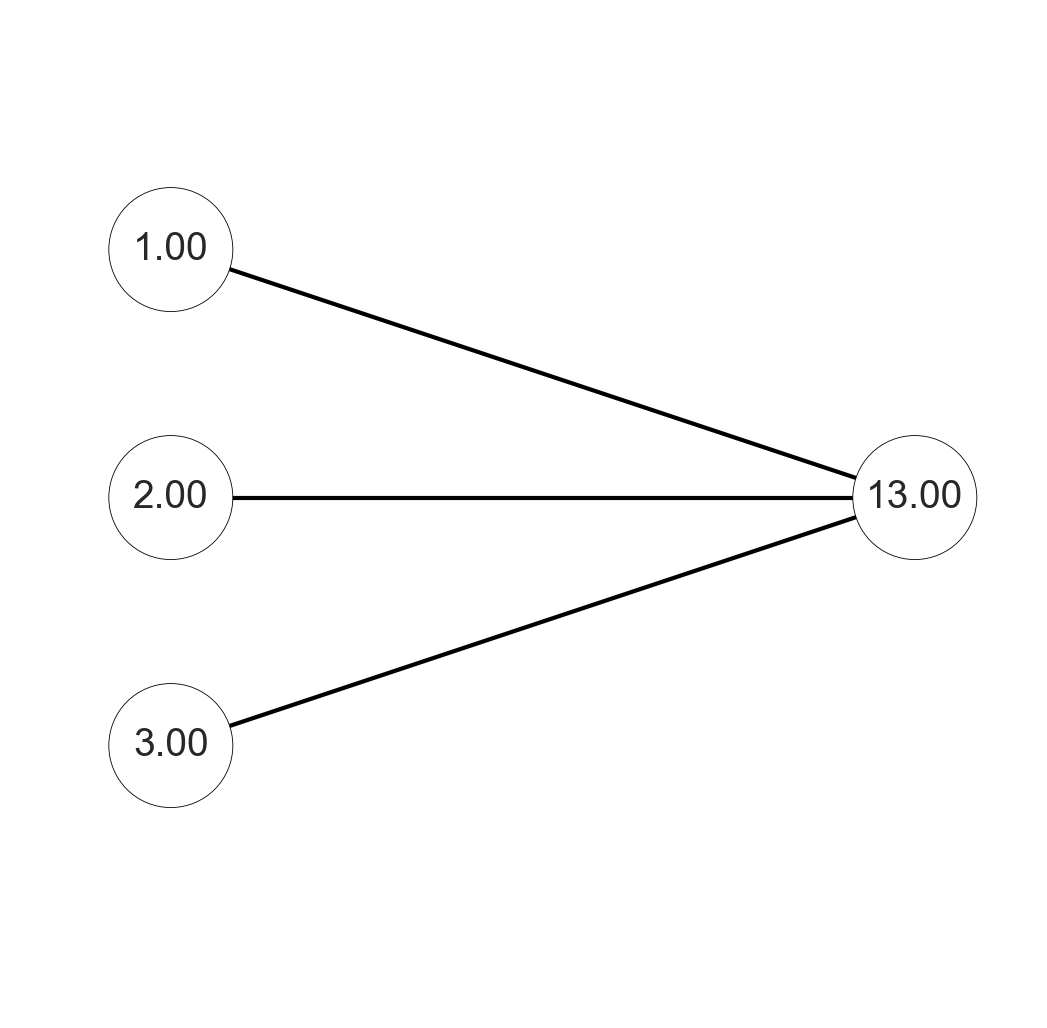

In [64]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
draw_neural_net(ax, [3, 1], layer_activations=np.array([[1,2,3], [13]]),
                weights=np.array([[0.5, 0.5, 0.5]]))

You can do the same for the hidden layer to the output layer. Initialize the hidden to output weights as well as the bias for the output weights, then you can use the function again.

In [65]:
hidden_to_output = np.random.randn(3,1)
print hidden_to_output
output_bias = np.array([-1])
print output_bias

[[-0.09694986]
 [-1.81975803]
 [ 2.43567468]]
[-1]


In [ ]:
output_act = layer_activation(hidden_act, hidden_to_output, output_bias)
output_act

---

### Matrix operation version of forward propagation

The activation function does not have to be linear, but for now we will have it linear for simplicity. Linear activation is a commonly used activation function in neural networks. There are other popular activations such as sigmoid, tanh, and ReLU as well that we will discuss later.

Recall the "vectorized" formulation of the forward propagation:

### $$ a^i = \sigma(W^i a^{i-1} + b^i) $$

$a$ are vectors of neuron activations for layer $i$, the $b$ is now a vector of biases, and $W$ indicates our weight matrix.

We can also define just the weighted input - the vector that is fed to the activation function - as a vector $z$:

### $$ z^i = (W^i a^{i-1} + b^i) $$

We can write the forward propagation functions above but using matrix operations. Define a function that will take the input layer, weight matrix, biases, and activation function and calculate the activations with linear algebra operations.

In [68]:
def forward(input_layer, weights, biases, activation_function=linear):
    input_rows = np.atleast_2d(input_layer)
    
    # calculate output layer activations
    output_activations = input_rows.dot(weights)
    
    return output_activations

You can see that this gives us the same result as above. This way of writing it will come in handy when you want to apply the operation to multiple observations of inputs at once.

In [69]:
hidden_act = forward(input_act, input_to_hidden, hidden_biases)
hidden_act

array([[-1.07603635,  0.1101821 , -0.41481955]])

In [ ]:
ouput

We can plot this out again with the activations for clarity.

---

### The XOR problem

Thus far, our setup is not terribly interesting or useful. Our goal in building a network is to construct a model, and for that we will need a problem to solve.

The XOR problem is a famous problem for neural networks. XOR is the symbol for "exclusive or", which is a logical operation that evaluates to `True` when A or B is present, but not both. 

We can set up our "data" below, with the inputs to XOR and our expected output.

In [71]:
XOR_in = np.array([[1,1], [1,0], [0,1], [0,0]])
XOR_out = np.array([[0,1,1,0]]).T

print XOR_in
print XOR_out

[[1 1]
 [1 0]
 [0 1]
 [0 0]]
[[0]
 [1]
 [1]
 [0]]


We will also need to specify a loss function. For now let's use the least squared loss, which we will code below.

In [72]:
def lsq_loss(y_true, y_pred):
    return np.mean(0.5 * (y_true - y_pred)**2)

What would be our loss right now, if we fed the inputs into the neural network?

We can put it through our function above to see.

In [73]:
def forward_pass(input_layer, weights_list, biases_list):
    activations = [input_layer]
    for W, b in zip(weights_list, biases_list):
        activations.append(forward(activations[-1], W, b))
    return activations

In [75]:
acts = forward_pass(XOR_in, [input_to_hidden, hidden_to_output], [hidden_biases, output_bias])
for a in acts:
    print a

[[1 1]
 [1 0]
 [0 1]
 [0 0]]
[[-1.40163831 -0.18781432 -0.74552858]
 [ 0.23430595 -1.32689931 -0.71652572]
 [-1.63594426  1.139085   -0.02900285]
 [ 0.          0.          0.        ]]
[[-1.33819984]
 [ 0.64669618]
 [-1.98489602]
 [ 0.        ]]


You'll notice that these are now for each observation.


---

### Backpropagation: calculating the adjustment of parameters to minimize loss

We would like to reduce our error on prediction. In order to do this, we will have to adjust the weights in our network. Backpropagation of error is the method in which neural netoworks adjust these weights. 

The crux of backpropagation is that we calculate the partial derivative of the cost function with respect to weights and biases. This is the same idea of gradient descent, where we incrementally tweak the values of coefficients down the gradient towards the minimum of the loss function. The only difficulty is that we now have layered coefficients and the derivative with respect to any one of them may be intractable to explicitly derive.

Luckily, backpropagation allows us to avoid deriving the full derivative of the cost function with respect to any given parameter. It leverages the chain rule of calculus to find the gradient through an iterative procedure.

To simplify things starting out, let's look at an even more basic neural network architecture. Now we have 3 layers, but only one node in each one:


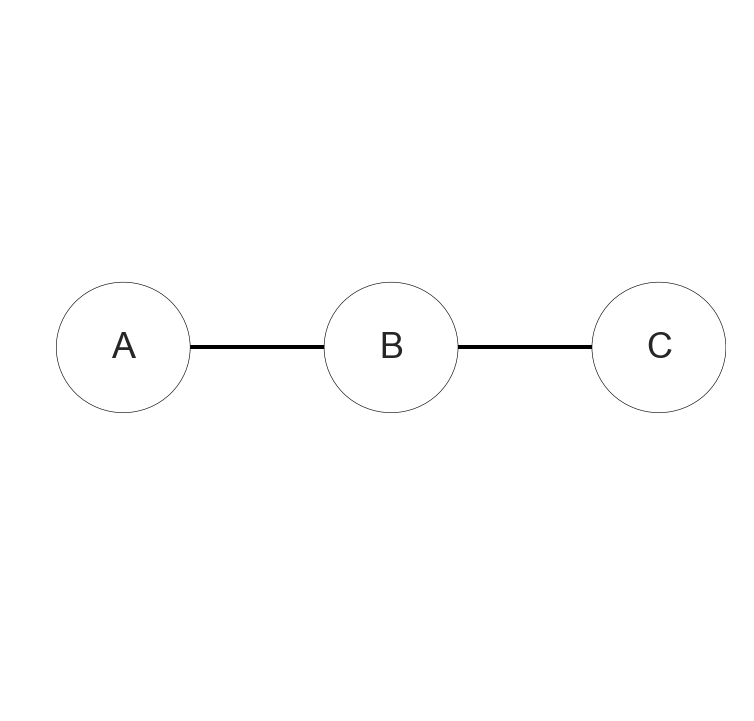

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
draw_neural_net(ax, [1, 1, 1], layer_activations=[['A'],['B'],['C']])


Say $MSE_x$ is our loss function for a single training example, we want to calculate:

### $$ \frac{\partial MSE_x}{\partial w} \\
\frac{\partial MSE_x}{\partial b} $$

Where $w$ are the weights between the neurons and $b$ are the biases. These partial derivatives will inform us how to adjust the values like in gradient descent to minimize the loss function.

We may have many observations - in the case of our XOR problem we have 4. Luckily we can recover the partial derivative of the entire cost function with respect to $w$ and $b$ by averaging over the input training samples. This is because our least squared loss function can be described as an average loss across the training examples.

Backpropagation is really about the backpropagation of the total error of the network (as defined by the loss/cost function) through to the neurons. One way of thinking about this is that each neuron will be assigned an amount of error that it is contributing to the overall error.

---

### The chain rule of calculus

The key to how backpropagation works lies in the chain rule. The chain rule is a method to compute the derivatives of functions that are compositions of other functions with known derivatives.

Say we have two functions, $f$ and $g$, and that we define variables $y$ and $z$ such that:

### $$ y = g(x) \\
z = f(g(x)) = f(y) $$

Where $x$ is a real number. These are functions that map real numbers to other real numbers, and they represent a dependent relationship. Specifically, the value of $z$ is dependent on the value of $y$. The chain rule is written as:

### $$ \frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \cdot \frac{\partial y}{\partial x} $$

Take our simple neural network we plotted above with neurons A, B, and C. We can write out some formulas for the activations of these neurons:

### $$ act_B(x) = \sigma (act_A(x) \cdot W_{AB} + b_{B}) \\
act_C(x) = \sigma (act_B(x) \cdot W_{BC} + b_{C})$$

So, therefore:

### $$ act_C(x) = \sigma (\sigma (act_A(x) \cdot W_{AB} + b_{B}) \cdot W_{BC} + b_{C}) $$

And:

### $$ \frac{\partial C}{x} = \frac{\partial C}{\partial B} \frac{\partial B}{\partial A} \frac{\partial A}{\partial x} $$

We have the dependent function relationship defined in the chain rule above. Say we want to compute the 

---

### Error of a single neuron

We can define the error of a neuron $j$ as:

### $$ \partial_j^i = \frac{\partial C}{\partial a_j^i} $$

Where $a_j^i$ is the activation of the neuron as calculated by the forward propagating activations times weights before we apply the activation function $\sigma$.

$C$ here represents the cost, or total error of the network. The entire right hand side of the equation represents the partial derivative of the loss with respect to the weighted input of neuron $j$ at layer $i$.


---

### Error of the output layer

In backpropagation we will work backwards from the output layer down, computing the error as calculated by derivatives at each step. The first step is to calculate the error of our output neurons. The error will be the derivative of our cost/loss $C$ with respect to the activation multiplied by the derivative our our activation function applied to the pre-function activation of our neurons $z_j^i$. The full formula is written as:

### $$ \partial_j^{out} = \frac{\partial C}{\partial a_j^{out}} \sigma' (z_j^{out}) $$

$\partial_j^{out}$ are the errors for each of the $j$ output nodes. In our case, there is just one output node, so we will just have $\partial^{out}$

$\frac{\partial C}{\partial a_j^{out}}$ is the derivative of the cost/loss with respect to the activations of the output neurons. Again, we only have a single output neuron.

$\sigma' (z_j^{out})$ is the derivative of the activation function applied to the weighted inputs to the neurons. We are using a linear activation function, and it's derivative evaluates to 1 regardless of input:

### $$ \text{linear}'(x) = 1 $$

For our simple neural network with a single output, we can simplify the equation:

### $$ \partial^{out} = \frac{\partial C}{\partial a^{out}}$$

This formula is derived using the chain rule:

### $$ \partial_j^{out} = \frac{\partial C}{\partial a_j^{out}} \frac{\partial a_j^{out}}{\partial z_j^{out}} = \frac{\partial C}{\partial a_j^{out}} \sigma' (z_j^{out}) $$

Since, 

### $$ a_j^{out} = \sigma (z_j^{out}) \\
\sigma' (z_j^{out}) = \frac{\partial a_j^{out}}{\partial z_j^{out}} $$


Our error is the derivative of the loss with respect to the output activation. Because we are using the least squares loss function (remember, we multiplied it by 0.5 earlier to cancel out the exponent in the derivative), we can further simplify this to:

### $$ \partial^{out} = - (y - a^{out}) \\
\partial^{out} = a^{out} - y  $$


---

### Equation for error based on the error of the layer above

Using the error of the output layer, we can calculate the error of the previous layer. We can keep doing this for each layer down the line. The equation to calculate the error of a layer from the error of the layer above it is:

### $$ \partial^i = ((W^{i+1})^T \partial^{i+1}) \circ \sigma' (z^i) $$

This is also derived using the chain rule. [The full proof (and a great overview of all the theory this lecture is primarily based on) of this can be found here.](http://neuralnetworksanddeeplearning.com/chap2.html)

The $\circ \sigma' (z^i)$ indicates a "hadamard product" which is an elementwise multiplication. Because we are using the linear activation and our derivative activation function outputs 1, we do not have to worry about this. If you did need to do it, you can use the `np.multiply` function.

With linear activation we can just write this:

### $$ \partial^i = ((W^{i+1})^T \partial^{i+1})$$


The $(W^{i+1})^T \partial^{i+1}$ section of the equation is interesting. It is doing the dot product of the transposed weights and the error from the layer up. The intuition behind this is that we are moving the error down to this layer in accordance with the weightings between this layer and the one above.

---

### Rate of change of cost/loss with respect to bias

The derivative of the cost function with respect to the bias for a neuron in a layer is equal to the error of the neuron. This is good news because we have the formula for the error already in the equation above.

### $$ \frac{\partial C}{\partial b_j^i} = \partial_j^i $$


---

### Rate of change of cost with respect to weights

The derivative of the cost function with respect to a weight is calculated with the activation input to that neuron multiplied by the error of the neuron. The equation is:

### $$ \frac{\partial C}{\partial w_{jk}^i} = a_k^{i-1} \partial_j^i $$

Specifically, this states that for weights between neuron $k$ in layer $i-1$ to to the neuron $j$ in layer $i$, the derivative of the cost function with respect to this weight is the activation of the input times the error of the neuron.

More casually:

### $$ \frac{\partial C}{\partial w_{jk}^i} = a_{in} \partial_{out} $$

Where $a_{in}$ is the activation of the neuron on the input side of the weight, and $\partial_{out}$ is the error for the neuron on the output side of the weight.

---

### Putting it all together into a neural network

Now that we have all of the requisite equations, we can code a class to build a neural network that will adjust its weights using backpropagation.

1. The class will need a function to perform the _forward_ propagation of the activations through the network given an input. This will give us the activations at each layer for the neurons.
2. We will also need a cost function and its derivative. This is how we will calculate the error of the network from the output layers.
3. Once we have the error of the network, we can create the _backwards_ propagation of this error/gradient from the output layer downwards. Our goal is to calculate the derivative of the cost function with respect to the weights and the biases, which are our parameters.
4. With the derivatives of the cost function of our parameters, we can update the weights and biases according to a learning rate parameter.

In [76]:
class DumbNet(object):
    
    activations = []
    
    def __init__(self, input_size=2, hidden_size=3, output_size=1):
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.input_to_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.hidden_to_input = np.random.randn(self.hidden_size, self.output_size)
        
        self.hidden_biases = np.ones(hidden_size)
        self.output_biases = np.ones(output_size)
        
    def linear(self, x):
        return x
    
    def linear_prime(self, x):
        return 1.
    
    def forward_prop(self, input_act):
        
        self.activations = [input_act]
        
        hidden_act = self.linear(input_act.dot(self.input_to_hidden) + self.hidden_biases)
#         print hidden_act
        
        output_act = self.linear(hidden_act.dot(self.hidden_to_output) + self.output_biases)
        
        self.activations.append(hidden_act)
        self.activations.append(output_act)
        
        return self.activations
    
    def lsq_loss(self, y_true, y_hat):
        return np.mean(0.5 * (y_true - y_hat)**2)
    
    def lsq_prime(self, y_true, y_hat):
        return np.mean(y_hat - y_true)
    
    def fit(self, X, y, epochs = 5, lr=0.05):
        
        for i in range(5):
            acts = self.forward_prop(X)
    
    def back_prop(self, input_act, y_true, y_hat):
        output_delta = self.lsq_prime(y_true, y_hat)
        
        input_act = self.activations[0]
        hidden_act = self.activations[1]
        output_act = self.activations[2]
        
        print self.hidden_to_output.T.dot(output_delta)
        

In [78]:
dn = DumbNet()
dn.forward_prop(XOR_in)

[[ 0.15605233  0.39419451  1.60240179]
 [ 0.95471824  1.31131392  2.78712225]
 [ 0.2013341   0.08288059 -0.18472046]
 [ 1.          1.          1.        ]]


In [ ]:
def forward_pass(input_layer, weights_list, biases_list):
    activations = [input_layer]
    for W, b in zip(weights_list, biases_list):
        activations.append(forward(activations[-1], W, b))
    return activations